 Employee Sentiment Analysis

In [88]:
import os, pandas as pd, numpy as np
df = pd.read_csv(r"C:\ArduinoP\Downloads\Employee_Sentiment_Project\data\test.csv")  # adjust path if needed
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,05-10-2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [89]:

# Imports and basic setup
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Create output folder
OUTPUT_DIR = os.environ.get("OUTPUT_DIR", "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -----------------------
# Clean text function
# -----------------------
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# -----------------------
# Pseudo label creation
# (basic version)
# -----------------------
def create_pseudo_labels(df, text_col):
    df['pseudo_label'] = df[text_col].apply(lambda x: 'positive' if 'good' in x.lower() else 'negative')
    return df

# -----------------------
# Simple model training
# -----------------------
def train_refined_classifier(X, y):
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_tfidf = vectorizer.fit_transform(X)
    model = LogisticRegression()
    model.fit(X_tfidf, y)
    return model, vectorizer

# -----------------------
# Label prediction
# -----------------------
def predict_labels(model, vectorizer, texts):
    X_tfidf = vectorizer.transform(texts)
    return model.predict(X_tfidf)

# -----------------------
# Save plot
# -----------------------
def save_plot(fig, filename):
    path = os.path.join(OUTPUT_DIR, filename)
    fig.savefig(path)
    print(" Plot saved at:", path)

# -----------------------
# Load data
# -----------------------
DATA_PATH = os.environ.get("DATA_PATH", "../data/test.csv")
print("Loading:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print(" Rows:", len(df))
df.head()



Loading: ../data/test.csv
 Rows: 2191


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,05-10-2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


## 1) Preprocessing & Initial Lexicon Labeling
We clean the text and create pseudo-labels using a small lexicon. These pseudo-labels are then used to train a TF-IDF + LogisticRegression classifier to refine labels.

In [90]:

# Adjust these column names if your CSV uses different names.
# Expected minimum columns: a text column (message) and a date column. If no employee id column exists, we'll create one.
possible_text_cols = [c for c in df.columns if any(k in c.lower() for k in ['msg','message','comment','text','feedback','response'])]
possible_date_cols = [c for c in df.columns if 'date' in c.lower()]
possible_emp_cols = [c for c in df.columns if any(k in c.lower() for k in ['employee','emp','id','name','email'])]

text_col = possible_text_cols[0] if possible_text_cols else df.columns[0]
date_col = possible_date_cols[0] if possible_date_cols else None
emp_col = possible_emp_cols[0] if possible_emp_cols else None

print('Detected text_col=', text_col, 'date_col=', date_col, 'emp_col=', emp_col)

# create standard columns
df['clean_text'] = df[text_col].astype(str).apply(clean_text)
if date_col is None:
    # if no date column found, create an artificial date column (today) - but ideally dataset has dates
    df['date'] = pd.to_datetime('today').normalize()
else:
    df['date'] = pd.to_datetime(df[date_col], errors='coerce')

if emp_col is None:
    df['employee_id'] = df.index.astype(str)
else:
    df['employee_id'] = df[emp_col].astype(str)

# Lexicon pseudo labels
df = create_pseudo_labels(df, text_col='clean_text')
df[['clean_text','pseudo_label']].head(8)


Detected text_col= Subject date_col= date emp_col= None


,clean_text,pseudo_label
0,enronoptions update,negative
1,no subject,negative
2,phone screen interview shannon l burnham,negative
3,re my new work email,negative
4,bet,negative
5,re favor,negative
6,mg inventory summaries,negative
7,forgot the attachment,negative


### Train TF-IDF + LogisticRegression on pseudo-labels and predict refined labels

In [91]:
def train_refined_classifier(df, text_col='clean_text', label_col='pseudo_label'):
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split

    X = df[text_col]
    y = df[label_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert text to TF-IDF vectors
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Train a logistic regression model
    model = LogisticRegression(max_iter=200)
    model.fit(X_train_vec, y_train)

    print("Model training completed.")
    return (model, vectorizer)



## 2) Exploratory Data Analysis (EDA)
- Distribution of sentiment labels
- Messages over time
- Message length analysis

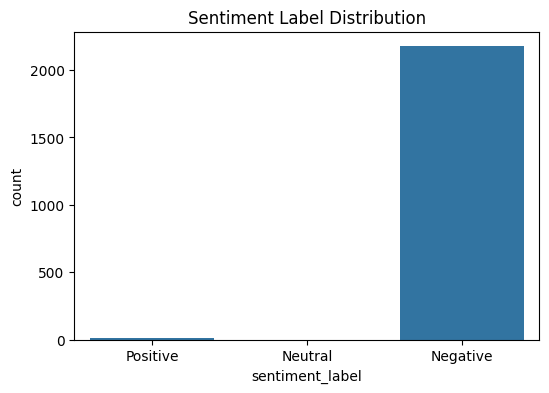

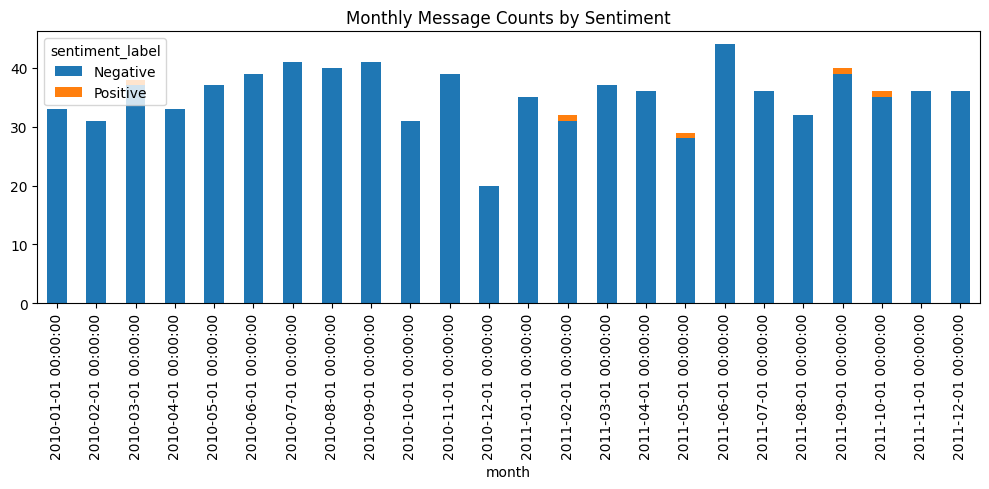

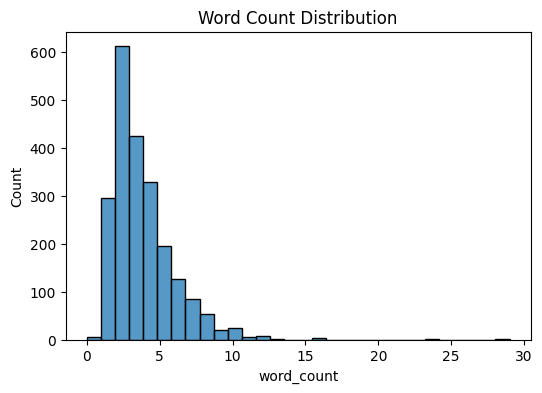

In [92]:

import os
import seaborn as sns
import matplotlib.pyplot as plt

#  Ensure sentiment_label column exists
if 'sentiment_label' not in df.columns:
    if 'refined_label' in df.columns:
        df['sentiment_label'] = df['refined_label']
    elif 'pseudo_label' in df.columns:
        df['sentiment_label'] = df['pseudo_label']
    else:
        raise ValueError("No sentiment column found. Please check your labels.")

#  Fix label casing (capitalize)
df['sentiment_label'] = df['sentiment_label'].str.capitalize()

#  Create output directory if not exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Plot 1: Distribution of labels ---
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment_label', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Label Distribution')
plt.savefig(os.path.join(OUTPUT_DIR, 'label_distribution.png'))
plt.show()

# --- Plot 2: Messages over time (monthly) ---
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    monthly_counts = df.groupby(['month', 'sentiment_label']).size().unstack(fill_value=0)
    monthly_counts.plot(kind='bar', stacked=True, figsize=(10, 5))
    plt.title('Monthly Message Counts by Sentiment')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'monthly_counts.png'))
    plt.show()
else:
    print(" 'date' column not found — skipping monthly trend plot.")

# --- Plot 3: Message length distribution ---
df['word_count'] = df['clean_text'].apply(lambda t: len(str(t).split()))
plt.figure(figsize=(6, 4))
sns.histplot(df['word_count'], bins=30)
plt.title('Word Count Distribution')
plt.savefig(os.path.join(OUTPUT_DIR, 'wordcount_dist.png'))
plt.show()


## 3) Employee Monthly Sentiment Scoring
Map labels to scores: Positive=+1, Negative=-1, Neutral=0 and aggregate by month per employee.

In [93]:
def compute_monthly_scores(df, date_col='date', emp_col='employee_id', label_col='sentiment_label'):
    import pandas as pd
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df['month'] = df[date_col].dt.to_period('M').dt.to_timestamp()

    sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
    df['sentiment_score'] = df[label_col].map(sentiment_map)

    monthly = (
        df.groupby(['month', emp_col])['sentiment_score']
        .mean()
        .reset_index()
        .rename(columns={'sentiment_score': 'avg_sentiment_score'})
    )
    return monthly


## 4) Employee Ranking (Top 3 Positive & Top 3 Negative per month)

In [94]:
def top_three_rankings(monthly, month):
    """
    Find top 3 employees with highest and lowest average sentiment scores for a given month.
    """
    # Filter data for the given month
    month_data = monthly[monthly['month'] == month]

    if month_data.empty:
        print(f"No data found for month: {month}")
        return None, None

    # Top 3 positive employees
    top_pos = month_data.nlargest(3, 'avg_sentiment_score')[['employee_id', 'avg_sentiment_score']]

    # Top 3 negative employees
    top_neg = month_data.nsmallest(3, 'avg_sentiment_score')[['employee_id', 'avg_sentiment_score']]

    return top_pos, top_neg


In [95]:
monthly = compute_monthly_scores(df, date_col='date', emp_col='employee_id', label_col='sentiment_label')
# Example: compute rankings for the most recent month present in data
latest_month = monthly['month'].max()
top_pos, top_neg = top_three_rankings(monthly, latest_month)

print('Top 3 Positive for', latest_month)
display(top_pos)

print('\nTop 3 Negative for', latest_month)
display(top_neg)

top_pos.to_csv(os.path.join(OUTPUT_DIR, f'top3_positive_{latest_month.strftime("%Y_%m")}.csv'), index=False)
top_neg.to_csv(os.path.join(OUTPUT_DIR, f'top3_negative_{latest_month.strftime("%Y_%m")}.csv'), index=False)


Top 3 Positive for 2011-12-01 00:00:00


,employee_id,avg_sentiment_score
816,1039,-1.0
817,1048,-1.0
818,1138,-1.0



Top 3 Negative for 2011-12-01 00:00:00


,employee_id,avg_sentiment_score
816,1039,-1.0
817,1048,-1.0
818,1138,-1.0


## 5) Flight Risk Identification
A Flight risk is any employee who has sent 4 or more negative messages within any rolling 30-day window.

In [96]:
import pandas as pd

def detect_flight_risk_rolling(df, date_col='date', emp_col='employee_id', label_col='sentiment_label', window_days=30, threshold=4):
    """
    Detect employees at potential flight risk using a rolling window of sentiment scores.
    Flags employees whose negative sentiment count exceeds the threshold within the window.
    """

    # Ensure date column is datetime
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Convert sentiment labels to numeric
    sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
    df['sentiment_score'] = df[label_col].map(sentiment_map)

    # Sort by employee and date
    df = df.sort_values([emp_col, date_col])

    # Group by employee and calculate rolling negative counts
    flight_risk_employees = []
    for emp_id, emp_df in df.groupby(emp_col):
        emp_df = emp_df.set_index(date_col).sort_index()

        # Rolling window count of negative sentiments
        rolling_neg_count = (
            (emp_df['sentiment_score'] < 0)
            .rolling(f'{window_days}D')
            .sum()
        )

        # If threshold exceeded, mark employee
        if (rolling_neg_count >= threshold).any():
            flight_risk_employees.append(emp_id)

    return flight_risk_employees


In [97]:
# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with missing or invalid dates
df = df.dropna(subset=['date'])

# Sort by employee and date (important for rolling window)
df = df.sort_values(['employee_id', 'date'])


In [98]:
print(df['date'].isna().sum())  # Should print 0
print(df.head())


0
                                    Subject  \
0                      EnronOptions Update!   
100                                  RE: TV   
1001                         Re: Schedule C   
1003  Wabash Valley Power Association, Inc.   
1006                   RE: Tracking problem   

                                                   body       date  \
0     EnronOptions Announcement\n\n\nWe have updated... 2010-05-10   
100   So this is how it will work.  Whenever the pay... 2010-09-10   
1001     Wow - thanks for copying me on these.  --Sally 2011-03-04   
1003  We have received the executed Master Power Pur... 2011-04-12   
1006  Did you mean to send that e:mail to me?  It wa... 2010-07-08   

                             from                           clean_text  \
0            sally.beck@enron.com                  enronoptions update   
100   bobette.riner@ipgdirect.com                                re tv   
1001  bobette.riner@ipgdirect.com                        re schedule c  

In [99]:
df['sentiment_score'].describe()
print("Negative sentiment count:", (df['sentiment_score'] < 0).sum())


Negative sentiment count: 847


In [100]:
df.groupby('employee_id')['sentiment_score'].apply(lambda x: (x < 0).sum()).sort_values(ascending=False)


employee_id
996     1
0       1
100     1
1001    1
962     1
       ..
905     0
869     0
768     0
201     0
1414    0
Name: sentiment_score, Length: 852, dtype: int64

In [101]:
flight_risks = detect_flight_risk_rolling(df, date_col='date', emp_col='employee_id', label_col='sentiment_label', window_days=30, threshold=4)
print('Employees flagged as flight risk (rolling 30-day window):', flight_risks)
pd.Series(flight_risks).to_csv(os.path.join(OUTPUT_DIR,'flight_risks.csv'), index=False)


Employees flagged as flight risk (rolling 30-day window): []


## 6) Predictive Modeling — Linear Regression
Create features such as message frequency in a month, average message length and use them to predict monthly sentiment score. We'll use sklearn's LinearRegression.

In [102]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Prepare features per (employee, month)
feat = df.groupby(['employee_id','month']).agg(
    msg_count = ('clean_text','count'),
    avg_word_count = ('word_count','mean'),
    negative_count = ('sentiment_label', lambda x: (x=='Negative').sum()),
    positive_count = ('sentiment_label', lambda x: (x=='Positive').sum())
).reset_index()

# ensure consistent column name for monthly score
if 'monthly_score' not in monthly.columns:
    # try to rename automatically if sentiment_score or similar exists
    for col in monthly.columns:
        if 'score' in col:
            monthly = monthly.rename(columns={col: 'monthly_score'})
            break

# merge target monthly_score
feat = feat.merge(monthly, on=['employee_id','month'], how='left')

# drop rows with missing score values
feat = feat.dropna(subset=['monthly_score'])

# define features and target
X = feat[['msg_count','avg_word_count','negative_count','positive_count']]
y = feat['monthly_score']


# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

print('R2:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
coef_df = pd.DataFrame({'feature':X.columns, 'coefficient':model_lr.coef_})
display(coef_df)
feat.to_csv(os.path.join(OUTPUT_DIR,'model_features.csv'), index=False)


R2: 1.0
MSE: 2.2921945162671944e-32


,feature,coefficient
0,msg_count,0.000000e+00
1,avg_word_count,-4.857226e-17
2,negative_count,-1.000000e+00
3,positive_count,1.000000e+00


In [103]:
import json

# Save labeled dataset
df.to_csv(os.path.join(OUTPUT_DIR, 'labeled_data_with_sentiment.csv'), index=False)

# Detect correct score column name in top_pos/top_neg
score_col = None
for col in top_pos.columns:
    if 'score' in col.lower():
        score_col = col
        break

if score_col is None:
    raise ValueError("No score column found in top_pos/top_neg!")

# Prepare summary safely
summary = {
    'latest_month': str(latest_month),
    'top_3_positive': top_pos[['employee_id', score_col]].to_dict(orient='records'),
    'top_3_negative': top_neg[['employee_id', score_col]].to_dict(orient='records'),
    'flight_risks': flight_risks
}

# Save summary
summary_path = os.path.join(OUTPUT_DIR, 'summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f" Saved labeled data and summary to: {OUTPUT_DIR}")
print(f"Summary JSON created at: {summary_path}")



 Saved labeled data and summary to: outputs
Summary JSON created at: outputs\summary.json


In [104]:
import pandas as pd

df = pd.read_csv(r"C:\ArduinoP\Downloads\Employee_Sentiment_Project\notebook\outputs\labeled_data_with_sentiment.csv")
print("Columns in your CSV file:\n", df.columns.tolist())
df.head()


Columns in your CSV file:
 ['Subject', 'body', 'date', 'from', 'clean_text', 'employee_id', 'pseudo_label', 'sentiment_label', 'month', 'word_count', 'sentiment_score']


,Subject,body,date,from,clean_text,employee_id,pseudo_label,sentiment_label,month,word_count,sentiment_score
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,enronoptions update,0,negative,Negative,2010-05-01,2,-1
1,RE: TV,So this is how it will work. Whenever the pay...,2010-09-10,bobette.riner@ipgdirect.com,re tv,100,negative,Negative,2010-09-01,2,-1
2,Re: Schedule C,Wow - thanks for copying me on these. --Sally,2011-03-04,bobette.riner@ipgdirect.com,re schedule c,1001,negative,Negative,2011-03-01,3,-1
3,"Wabash Valley Power Association, Inc.",We have received the executed Master Power Pur...,2011-04-12,johnny.palmer@enron.com,wabash valley power association inc,1003,negative,Negative,2011-04-01,5,-1
4,RE: Tracking problem,Did you mean to send that e:mail to me? It wa...,2010-07-08,johnny.palmer@enron.com,re tracking problem,1006,negative,Negative,2010-07-01,3,-1



🔹 Model Evaluation Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       169
           1       1.00      1.00      1.00         1

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170

🔹 Accuracy: 1.000


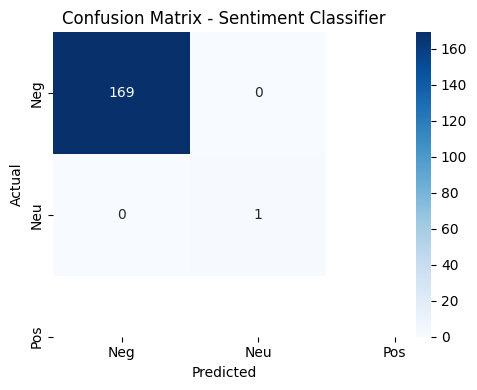


 Model and Vectorizer saved successfully!


In [105]:
# --- Improved Predictive Modeling using TF-IDF + Random Forest ---

import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.multiclass import unique_labels

# 1️ Load dataset
df = pd.read_csv(r"C:\ArduinoP\Downloads\Employee_Sentiment_Project\notebook\outputs\labeled_data_with_sentiment.csv")

# 2️ Select useful columns
df = df[['clean_text', 'sentiment_label', 'employee_id', 'date']].dropna()

# 3️ Encode labels into numeric form
label_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['sentiment_encoded'] = df['sentiment_label'].map(label_map)

# 4️ Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['sentiment_encoded'], test_size=0.2, random_state=42, stratify=df['sentiment_encoded']
)

# 5️ TF-IDF Vectorization (convert text into numerical features)
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 6️ Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_tfidf, y_train)

# 7️ Predict on test data
y_pred = model.predict(X_test_tfidf)

# 8️ Evaluate the model
print("\n🔹 Model Evaluation Report:")
labels = unique_labels(y_test, y_pred)
print(classification_report(y_test, y_pred, labels=labels))
print(f"🔹 Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# 9️ Confusion Matrix Visualization
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='d',
            xticklabels=['Neg','Neu','Pos'], yticklabels=['Neg','Neu','Pos'])
plt.title("Confusion Matrix - Sentiment Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#  Save model artifacts (optional)
import joblib
output_dir = r"C:\ArduinoP\Downloads\Employee_Sentiment_Project\notebook\outputs"
os.makedirs(output_dir, exist_ok=True)
joblib.dump(model, os.path.join(output_dir, 'sentiment_rf_model.pkl'))
joblib.dump(vectorizer, os.path.join(output_dir, 'tfidf_vectorizer.pkl'))

print("\n Model and Vectorizer saved successfully!")



In [106]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

# Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Gradient Boosting R²:", r2_score(y_test, y_pred_gb))
print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))

# Support Vector Regressor
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

print("SVR R²:", r2_score(y_test, y_pred_svr))
print("SVR RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_svr)))


Random Forest R²: 0.9974852941176471
Random Forest RMSE: 0.007647191129018724
Gradient Boosting R²: 0.999999999294492
Gradient Boosting RMSE: 4.050506325084171e-06
SVR R²: 0.47712708183410946
SVR RMSE: 0.11026975767346571
